Mount to Google Drive directory

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#%cd /content/drive/My\ Drive/pied-paper

Change PyTorch and Torchtext version (using legacy features)

In [4]:
!pip install --upgrade torch==1.8.0
!pip install --upgrade torchtext==0.9.0
# !pip show torch
# !pip show torchtext

You should consider upgrading via the 'C:\Users\paulh\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\paulh\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Data has already been preprocessed; it is in 'preprocessed/'

In [16]:
!pip install sklearn
!pip install seaborn
!pip install spacy
!python -m spacy download en

You should consider upgrading via the 'C:\Users\paulh\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\paulh\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\paulh\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


     ---------------------------------------- 12.8/12.8 MB 5.0 MB/s eta 0:00:00
[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


You should consider upgrading via the 'C:\Users\paulh\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torchtext.legacy.data import Field, TabularDataset, BucketIterator

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load data as train, valid, test data

In [19]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.long)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True, fix_length=200)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path='preprocessed', train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3, vectors="glove.6B.100d")

.vector_cache\glove.6B.zip: 862MB [03:10, 4.52MB/s]                               
100%|█████████▉| 399999/400000 [00:27<00:00, 14768.17it/s]


Build vocabulary and print example words

In [20]:
examples = train.examples
print("Number of tokens: ", len(examples[0].text))
print("\n")
print("Print first 200 tokens: ",examples[0].text[:200])
print("\n")
print("Print last 10 tokens: ",examples[0].text[-10:])

Number of tokens:  21


Print first 200 tokens:  ['killing', 'obama', 'administration', 'rules', ',', 'dismantling', 'obamacare', 'and', 'pushing', 'through', 'tax', 'reform', 'are', 'on', 'the', 'early', 'to', '-', 'do', 'list', '.']


Print last 10 tokens:  ['reform', 'are', 'on', 'the', 'early', 'to', '-', 'do', 'list', '.']


In [21]:
vocab = text_field.vocab

In [22]:

print("Vocabulary size: ", len(vocab))
print("10 most frequent words: ", vocab.freqs.most_common(10))

Vocabulary size:  6246
10 most frequent words:  [('the', 11014), (',', 8985), ('.', 6928), ('to', 4867), ('of', 4833), ('and', 4128), ('a', 4090), ('in', 3603), ('that', 2402), ('is', 1911)]


In [23]:
print("First 10 words: ", vocab.itos[0:10])
print("First 200 words of text data: ", train.examples[0].text[:200])
print("Index of the first word: ", vocab.stoi[train.examples[0].text[0]])

First 10 words:  ['<unk>', '<pad>', 'the', ',', '.', 'to', 'of', 'and', 'a', 'in']
First 200 words of text data:  ['killing', 'obama', 'administration', 'rules', ',', 'dismantling', 'obamacare', 'and', 'pushing', 'through', 'tax', 'reform', 'are', 'on', 'the', 'early', 'to', '-', 'do', 'list', '.']
Index of the first word:  708


MLP

Class definition

In [24]:
class TextClass(nn.Module):
  def __init__(self):
    super(TextClass, self).__init__()
    self.embed = nn.Embedding(len(vocab), embedding_dim=100)
    self.embed.weight.data.copy_(vocab.vectors)
    self.fc = nn.Linear(in_features=200*100, out_features=2)
  def forward(self, input, lengths=None):
    embed = self.embed(input)

    if lengths is not None:
      lengths = lengths.view(-1).tolist()
      packed_emb = pack_padded_sequence(embed, lengths)

    embed = embed.reshape(-1, 200*100)

    fc = self.fc(embed)
    out = fc

    return out

Data shape, for debugging purposes

In [25]:
data = next(iter(train_iter))
(x, x_len), y = data.titletext, data.label
print(x.shape)
print(x_len.shape)
print(y.shape)

torch.Size([32, 200])
torch.Size([32])
torch.Size([32])


Initialize model, optimizer, and loss criterion

In [26]:
device = 'cpu'
model = TextClass().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
print(model)

TextClass(
  (embed): Embedding(6246, 100)
  (fc): Linear(in_features=20000, out_features=2, bias=True)
)


Train model with backpropagation, plot resulting loss curve

Batch num: 0
Input data shape: 
[torchtext.legacy.data.batch.Batch of size 32]
	[.label]:[torch.LongTensor of size 32]
	[.title]:('[torch.LongTensor of size 32x200]', '[torch.LongTensor of size 32]')
	[.text]:('[torch.LongTensor of size 32x200]', '[torch.LongTensor of size 32]')
	[.titletext]:('[torch.LongTensor of size 32x200]', '[torch.LongTensor of size 32]')
	Epoch 0 | Batch 0 | Loss   0.65
Epoch 0 | Loss   1.14
Batch num: 0
Input data shape: 
[torchtext.legacy.data.batch.Batch of size 32]
	[.label]:[torch.LongTensor of size 32]
	[.title]:('[torch.LongTensor of size 32x200]', '[torch.LongTensor of size 32]')
	[.text]:('[torch.LongTensor of size 32x200]', '[torch.LongTensor of size 32]')
	[.titletext]:('[torch.LongTensor of size 32x200]', '[torch.LongTensor of size 32]')
	Epoch 1 | Batch 0 | Loss   0.15
Epoch 1 | Loss   0.83
Batch num: 0
Input data shape: 
[torchtext.legacy.data.batch.Batch of size 32]
	[.label]:[torch.LongTensor of size 32]
	[.title]:('[torch.LongTensor of size 32x

Epoch 19 | Loss   0.25


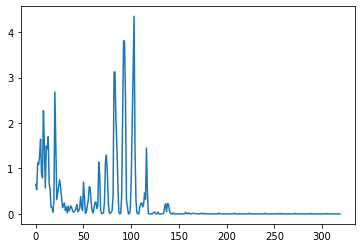

In [27]:
epochs = 20

model.train()

losses = []
for epoch in range(epochs):

  for batch_num, data in enumerate(train_iter):
    (x, x_len), y = data.titletext, data.label

    if batch_num == 0:
      print(f"Batch num: {batch_num}")
      print(f"Input data shape: {data}")
    else:
      pass

    optimizer.zero_grad()
    x = x.to(device)
    y = y.to(device)

    
    output = model(x.reshape(-1,200))
    #if batch_num == 0:
    #  print(output)
    
    loss = criterion(output, y)
    loss.backward()
    losses.append(loss.item())

    optimizer.step()
    
    if batch_num % 100 == 0:
      print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
  
  print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))
plt.plot(losses)

Test of embedding layer, for debugging purposes

In [28]:
embedding = nn.Embedding(len(vocab), 100)
input = torch.LongTensor([[1,2,3,4,5],[6,7,8,9,10]])
print(embedding(input).shape)

torch.Size([2, 5, 100])


In [29]:
data = next(iter(test_iter))
(x, x_len), y = data.titletext, data.label
print(model(x).argmax(dim=1))

tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1])


Evaluate model, for accuracy on test set

In [30]:
import itertools

model.eval()
with torch.no_grad():
        predictions = []
        num = 1
        for data in test_iter:
            (x, x_len), y_targ = data.titletext, data.label

            x = x.to(device)
            y_targ = y_targ.to(device)

            output = model(x).argmax(dim=1)
            #for y in output:
            #    writer.writerow({fieldnames[0]: image_id,fieldnames[1]: y.item()})
            #    image_id += 1
            
            if len(test_iter) % num == 5:
              print(output)
              print(y_targ)
              print(output.shape)
              print(torch.eq(output, y_targ))
              #print(sum(torch.eq(output, y_targ)).item())

            num += 1
            eq = torch.eq(output, y_targ)
            for element in eq:
              predictions.append(element)
        
        accuracy = sum(predictions) / len(predictions)
        print(f"Length of predictions: {len(predictions)}")
        print(f"Accuracy : {accuracy}")
        

tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32])
tensor([ True,  True, False,  True,  True, False, False,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True, False,  True, False,  True,  True,  True,  True,  True,
         True, False])
Length of predictions: 5670
Accuracy : 0.7696648836135864


In [31]:
print(len(train_iter))
print(len(valid_iter))
print(len(test_iter))

16
4
178


CNN

In [32]:
class TextClassCNN(nn.Module):
  def __init__(self):
    super(TextClassCNN, self).__init__()
    self.embed = nn.Embedding(len(vocab), embedding_dim=100)
    self.embed.weight.data.copy_(vocab.vectors)
    self.seq = nn.Sequential(
        nn.Conv2d(in_channels=100, out_channels=64, kernel_size=(3,1), padding=(1,0)),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,1), padding=(1,0)),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,1), padding=(1,0)),
        nn.ReLU()
    )
    self.fc = nn.Linear(in_features=16*200, out_features=2)
  def forward(self, input, lengths=None):
    embed = self.embed(input)

    if lengths is not None:
      lengths = lengths.view(-1).tolist()
      packed_emb = pack_padded_sequence(embed, lengths)

    embed = embed.reshape(-1, 100, 200, 1)

    seq = self.seq(embed)
    res = seq.reshape(-1, 16*200)

    fc = self.fc(res)
    out = fc

    return out

In [33]:
data = next(iter(train_iter))
(x, x_len), y = data.titletext, data.label
print(x.shape)
print(x_len.shape)
print(y.shape)

torch.Size([32, 200])
torch.Size([32])
torch.Size([32])


In [34]:
device = 'cpu'
cnn_model = TextClassCNN().to(device)
optimizer = torch.optim.Adam(cnn_model.parameters())
criterion = nn.CrossEntropyLoss()
print(cnn_model)

TextClassCNN(
  (embed): Embedding(6246, 100)
  (seq): Sequential(
    (0): Conv2d(100, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (5): ReLU()
  )
  (fc): Linear(in_features=3200, out_features=2, bias=True)
)


Batch num: 0
Input data shape: 
[torchtext.legacy.data.batch.Batch of size 32]
	[.label]:[torch.LongTensor of size 32]
	[.title]:('[torch.LongTensor of size 32x200]', '[torch.LongTensor of size 32]')
	[.text]:('[torch.LongTensor of size 32x200]', '[torch.LongTensor of size 32]')
	[.titletext]:('[torch.LongTensor of size 32x200]', '[torch.LongTensor of size 32]')
	Epoch 0 | Batch 0 | Loss   0.70
Epoch 0 | Loss   0.71
Batch num: 0
Input data shape: 
[torchtext.legacy.data.batch.Batch of size 32]
	[.label]:[torch.LongTensor of size 32]
	[.title]:('[torch.LongTensor of size 32x200]', '[torch.LongTensor of size 32]')
	[.text]:('[torch.LongTensor of size 32x200]', '[torch.LongTensor of size 32]')
	[.titletext]:('[torch.LongTensor of size 32x200]', '[torch.LongTensor of size 32]')
	Epoch 1 | Batch 0 | Loss   0.69
Epoch 1 | Loss   0.70
Batch num: 0
Input data shape: 
[torchtext.legacy.data.batch.Batch of size 32]
	[.label]:[torch.LongTensor of size 32]
	[.title]:('[torch.LongTensor of size 32x

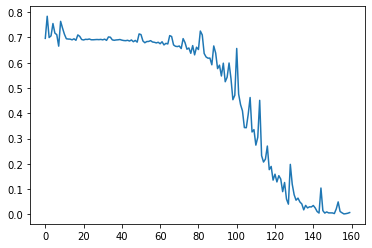

In [35]:
epochs = 10

cnn_model.train()

losses = []
for epoch in range(epochs):

  for batch_num, data in enumerate(train_iter):
    (x, x_len), y = data.titletext, data.label

    if batch_num == 0:
      print(f"Batch num: {batch_num}")
      print(f"Input data shape: {data}")
    else:
      pass

    optimizer.zero_grad()
    x = x.to(device)
    y = y.to(device)

    
    output = cnn_model(x)
    #if batch_num == 0:
    #  print(output)
    
    loss = criterion(output, y)
    loss.backward()
    losses.append(loss.item())

    optimizer.step()
    
    if batch_num % 100 == 0:
      print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
  
  print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))
plt.plot(losses)

In [36]:
import itertools

cnn_model.eval()
with torch.no_grad():
        predictions = []
        num = 1
        for data in test_iter:
            (x, x_len), y_targ = data.titletext, data.label

            x = x.to(device)
            y_targ = y_targ.to(device)

            output = cnn_model(x).argmax(dim=1)
            #for y in output:
            #    writer.writerow({fieldnames[0]: image_id,fieldnames[1]: y.item()})
            #    image_id += 1
            
            if len(test_iter) % num == 5:
              print(output)
              print(y_targ)
              print(output.shape)
              print(torch.eq(output, y_targ))
              #print(sum(torch.eq(output, y_targ)).item())

            num += 1
            eq = torch.eq(output, y_targ)
            for element in eq:
              predictions.append(element)
        
        accuracy = sum(predictions) / len(predictions)
        print(f"Length of predictions: {len(predictions)}")
        print(f"Accuracy : {accuracy}")
        

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32])
tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True,
        False,  True,  True,  True,  True,  True,  True, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])
Length of predictions: 5670
Accuracy : 0.7209876775741577


RNN

In [37]:
input_size = 100
sequence_length = 200
hidden_size = 128
num_layers = 1
num_classes = 10

In [38]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(RNN, self).__init__()
    self.input_size = input_size
    self.sequence_length = 28
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_classes = num_classes

    self.embed = nn.Embedding(len(vocab), embedding_dim=100)
    self.embed.weight.data.copy_(vocab.vectors)

    self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, batch_first = True)  
    self.linear = nn.Linear(self.hidden_size, self.num_classes)
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    embed = self.embed(x)
    #embed = embed.reshape(-1, 200*100)

    out, _ = self.rnn(embed, h0)
    out = out[:, -1, :]

    out = self.linear(out)
    return out

In [39]:
#  test = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
#  x, y = next(train(iter))
#  x = x[1][0]
#  y = x
#
#  h0 = torch.zeros(num_layers, x.size(0), hidden_size)

In [40]:
device = 'cpu'
rnn_model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = torch.optim.Adam(rnn_model.parameters())
criterion = nn.CrossEntropyLoss()

In [41]:
batch_num, input_data = next(enumerate(train_iter))
x, y_targ = input_data
print(batch_num)
print(x[0])
print(x[1][0].shape)
print(x[1][1])

0
tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1])
torch.Size([32, 200])
tensor([ 9, 13, 12,  8, 11,  9, 15, 20,  8, 13,  5,  7, 17, 11,  5, 13,  8,  7,
         6,  9,  3,  8,  7,  8,  8,  8,  9,  7,  7,  8,  9,  6])


Batch num: 0
Input data shape: torch.Size([32, 200])
	Epoch 0 | Batch 0 | Loss   2.22
Epoch 0 | Loss   1.69
Batch num: 0
Input data shape: torch.Size([32, 200])
	Epoch 1 | Batch 0 | Loss   2.39
Epoch 1 | Loss   1.34
Batch num: 0
Input data shape: torch.Size([32, 200])
	Epoch 2 | Batch 0 | Loss   0.76
Epoch 2 | Loss   1.14
Batch num: 0
Input data shape: torch.Size([32, 200])
	Epoch 3 | Batch 0 | Loss   0.70
Epoch 3 | Loss   1.04
Batch num: 0
Input data shape: torch.Size([32, 200])
	Epoch 4 | Batch 0 | Loss   0.69
Epoch 4 | Loss   0.98
Batch num: 0
Input data shape: torch.Size([32, 200])
	Epoch 5 | Batch 0 | Loss   0.69
Epoch 5 | Loss   0.93
Batch num: 0
Input data shape: torch.Size([32, 200])
	Epoch 6 | Batch 0 | Loss   0.69
Epoch 6 | Loss   0.90
Batch num: 0
Input data shape: torch.Size([32, 200])
	Epoch 7 | Batch 0 | Loss   0.69
Epoch 7 | Loss   0.88
Batch num: 0
Input data shape: torch.Size([32, 200])
	Epoch 8 | Batch 0 | Loss   0.69
Epoch 8 | Loss   0.86
Batch num: 0
Input data shap

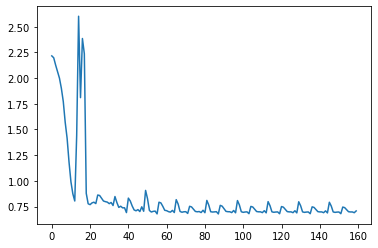

In [42]:
epochs = 10
batch_size = 32

rnn_model.train()

losses=[]
for epoch in range(epochs):
  for batch_num, input_data in enumerate(train_iter):
    if batch_num == 0 or batch_num == round(len(input_data) / batch_size)-1:
      print(f"Batch num: {batch_num}")
      i1, i2 = input_data
      print(f"Input data shape: {i1[1][0].shape}")
    else:
      pass
    
    optimizer.zero_grad()
    a, b = input_data
    x = a[1][0]
    y = a[0]
    x = x.to(device)
    y = y.to(device)

    output = rnn_model(x)
    loss = criterion(output, y)
    loss.backward()
    losses.append(loss.item())

    optimizer.step()

    if batch_num % 100 == 0:
      print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
  print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))
plt.plot(losses)


In [43]:
import csv
rnn_model.eval()

with open('cnn_submission.csv', 'w') as f:
    fieldnames = ['ImageId', 'Label']
    writer = csv.DictWriter(f, fieldnames=fieldnames, lineterminator = '\n')
    writer.writeheader()
    image_id = 1

    with torch.no_grad():
        predictions = []
        num = 1
        for a, b in test_iter:
            x = a[1][0]
            y_targ = a[0]

            output = rnn_model(x).argmax(dim=1)
            for y in output:
                writer.writerow({fieldnames[0]: image_id,fieldnames[1]: y.item()})
                image_id += 1
            
            if len(test_iter) % num == 5:
              print(output)
              print(y_targ)

            num += 1
            predictions.append(torch.eq(output, y_targ))
        
        print(predictions[0])
        print(predictions[0].shape)
        print(sum(predictions[:2]))
        print(len(predictions))
        tot_sum = 0
        tot_len = 0
        for tensor in predictions:
          tot_sum += sum(tensor)
          tot_len += len(tensor)
        accuracy = tot_sum / tot_len
        print(f"Length of predictions: {tot_len}")
        print(f"Accuracy : {accuracy}")
        

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False, False,  True, False,
        False, False, False, False, False, False,  True, False, False, False,
        False, False])
torch.Size([32])
tensor([2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 1])
178
Length of predictions: 5670
Accuracy : 0.5033509731292725
